# Pseudocode

 ## Cleaning:
    - NaN/?/Blank
        - waterfront
        - view
        - yr_rennovated
        - sqft_basement
    - whitespace *no issue
    - format to int/float
        - view
        - waterfront
        - condition
        - grade
        - sqft_basement
    - deal with dupes
        - several properties are listed more than once, suggesting they were bought/sold during this timeframe. 
    - categorical encoding
        - bedrooms
        - bathrooms
        - floors
        - zipcode
        - waterfront
        - view
        - condition
        - grade
    - duplicate properties
        - Located, need to decide how to treat. 
    - drop unused columns
        - lat/long once done with all other steps. Technically this combination is categorical.
        - date
        - sqft_basement? - 454 records do not have a value here--we would need to drop these records at a minimum.
    - save cleaned data
    
    
 ## Simple Model
     - add features
     - transform features (log transform?)
     
     
     
 ## Business Problem/Stakeholders
 
 We (Antom Research) are based in King County and working on a project for a real estate investment trust. They would like us to use our area expertise to advise them on what sort of properties are likely to maximize the value of their investment. They have been tight-lipped about their plans for the properties they purchase, so we do not know if they intend to buy and hold, rennovate, demolish and rebuild, etc.
 
   
     
     

## Data Understanding

## 

# Imports

In [1]:
# Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm


from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# Simple Data - omitted columns recommended in project description


In [2]:
simple_housing = pd.read_csv('../data/kc_house_data.csv')

In [3]:
complexities = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

In [4]:
simple_housing.drop(columns=complexities, inplace=True)

In [5]:
simple_housing.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,Average,7 Average,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987


In [6]:
# Add price per square foot feature
simple_housing['price_sqft'] = simple_housing['price'] / simple_housing['sqft_living']

In [7]:
# drop waterfront & confirm no NaNs
simple_housing = simple_housing.drop(columns='waterfront')
simple_housing.isna().sum()

id             0
price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
condition      0
grade          0
yr_built       0
price_sqft     0
dtype: int64

In [8]:
simple_housing.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,price_sqft
0,7129300520,221900.0,3,1.00,1180,5650,1.0,Average,7 Average,1955,188.050847
1,6414100192,538000.0,3,2.25,2570,7242,2.0,Average,7 Average,1951,209.338521
2,5631500400,180000.0,2,1.00,770,10000,1.0,Average,6 Low Average,1933,233.766234
3,2487200875,604000.0,4,3.00,1960,5000,1.0,Very Good,7 Average,1965,308.163265
4,1954400510,510000.0,3,2.00,1680,8080,1.0,Average,8 Good,1987,303.571429


In [9]:
# Identify catgeorical values & create new df with only the categorical columns.
categoricals = ['condition', 'grade']
cat_df = simple_housing[categoricals]
cat_df.head()

,condition,grade
0,Average,7 Average
1,Average,7 Average
2,Average,6 Low Average
3,Very Good,7 Average
4,Average,8 Good


In [10]:
# OneHot encoding for categorical variables. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
categorical_cats = ohe.fit_transform(cat_df)
categorical_cats.todense()
categorical_df = pd.DataFrame(categorical_cats.todense(), columns=ohe.get_feature_names(categoricals))
categorical_df.head()

,condition_Fair,condition_Good,condition_Poor,condition_Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# Confirm identical # of records before concatenating.
print(categorical_df.shape)
print(simple_housing.shape)

(21597, 14)
(21597, 11)


In [12]:
# Drop origical categorical columns, concatenate encoded columns.
data = simple_housing.drop(columns=categoricals)
kc_encoded = pd.concat([data.reset_index(drop=True), categorical_df.reset_index(drop=True)], axis=1)

In [13]:
# Confirm no new records added & categoricals are gone.
print(kc_encoded.shape)
kc_encoded.info()

(21597, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21597 non-null  int64  
 1   price                21597 non-null  float64
 2   bedrooms             21597 non-null  int64  
 3   bathrooms            21597 non-null  float64
 4   sqft_living          21597 non-null  int64  
 5   sqft_lot             21597 non-null  int64  
 6   floors               21597 non-null  float64
 7   yr_built             21597 non-null  int64  
 8   price_sqft           21597 non-null  float64
 9   condition_Fair       21597 non-null  float64
 10  condition_Good       21597 non-null  float64
 11  condition_Poor       21597 non-null  float64
 12  condition_Very Good  21597 non-null  float64
 13  grade_11 Excellent   21597 non-null  float64
 14  grade_12 Luxury      21597 non-null  float64
 15  grade_13 Mansion     215

In [14]:
# Save off encoded data
kc_encoded.to_csv('../data/kc_encoded.csv')

## Dummy Regressor

In [15]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.linear_model import LinearRegression

X = kc_encoded.drop(columns=['price_sqft', 'id'])
y = kc_encoded['price_sqft']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41, test_size=0.33)
lm = LinearRegression().fit(X_train, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)
y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)


In [17]:
print('Linear model, coefficients: ', lm.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, y_predict_dummy_mean)))
print("Mean squared error (linear model): {:.2f}".format(mean_squared_error(y_test, y_predict)))

print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, y_predict_dummy_median)))
print("Median absolute error (linear model): {:.2f}".format(median_absolute_error(y_test, y_predict)))

print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_predict)))


Linear model, coefficients:  [ 3.52940381e-04 -6.81607734e+00 -2.40699002e+00 -1.10785750e-01
  4.86465066e-05  9.65157285e+00 -5.00111053e-01 -2.12973209e+01
 -2.73569718e+00  1.71814935e+01 -4.29639374e+00 -1.37373515e+01
 -9.99269027e+01 -3.92655980e+02  1.04692406e+02  3.15455782e+01
 -5.16796518e+01 -4.76860280e+01 -3.32404548e+01 -1.46802236e+01
  1.27427061e+00]
Mean squared error (dummy): 11965.15
Mean squared error (linear model): 2494.72
Median absolute error (dummy): 65.70
Median absolute error (linear model): 22.20
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.03
r2_score (linear model): 0.79


## Exploring kc_encoded

In [18]:
# define X, y
X = kc_encoded.drop(columns=['price_sqft', 'id'])
y = kc_encoded['price_sqft']

In [19]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [50]:
train_df = pd.concat([X_train, y_train], axis=1)

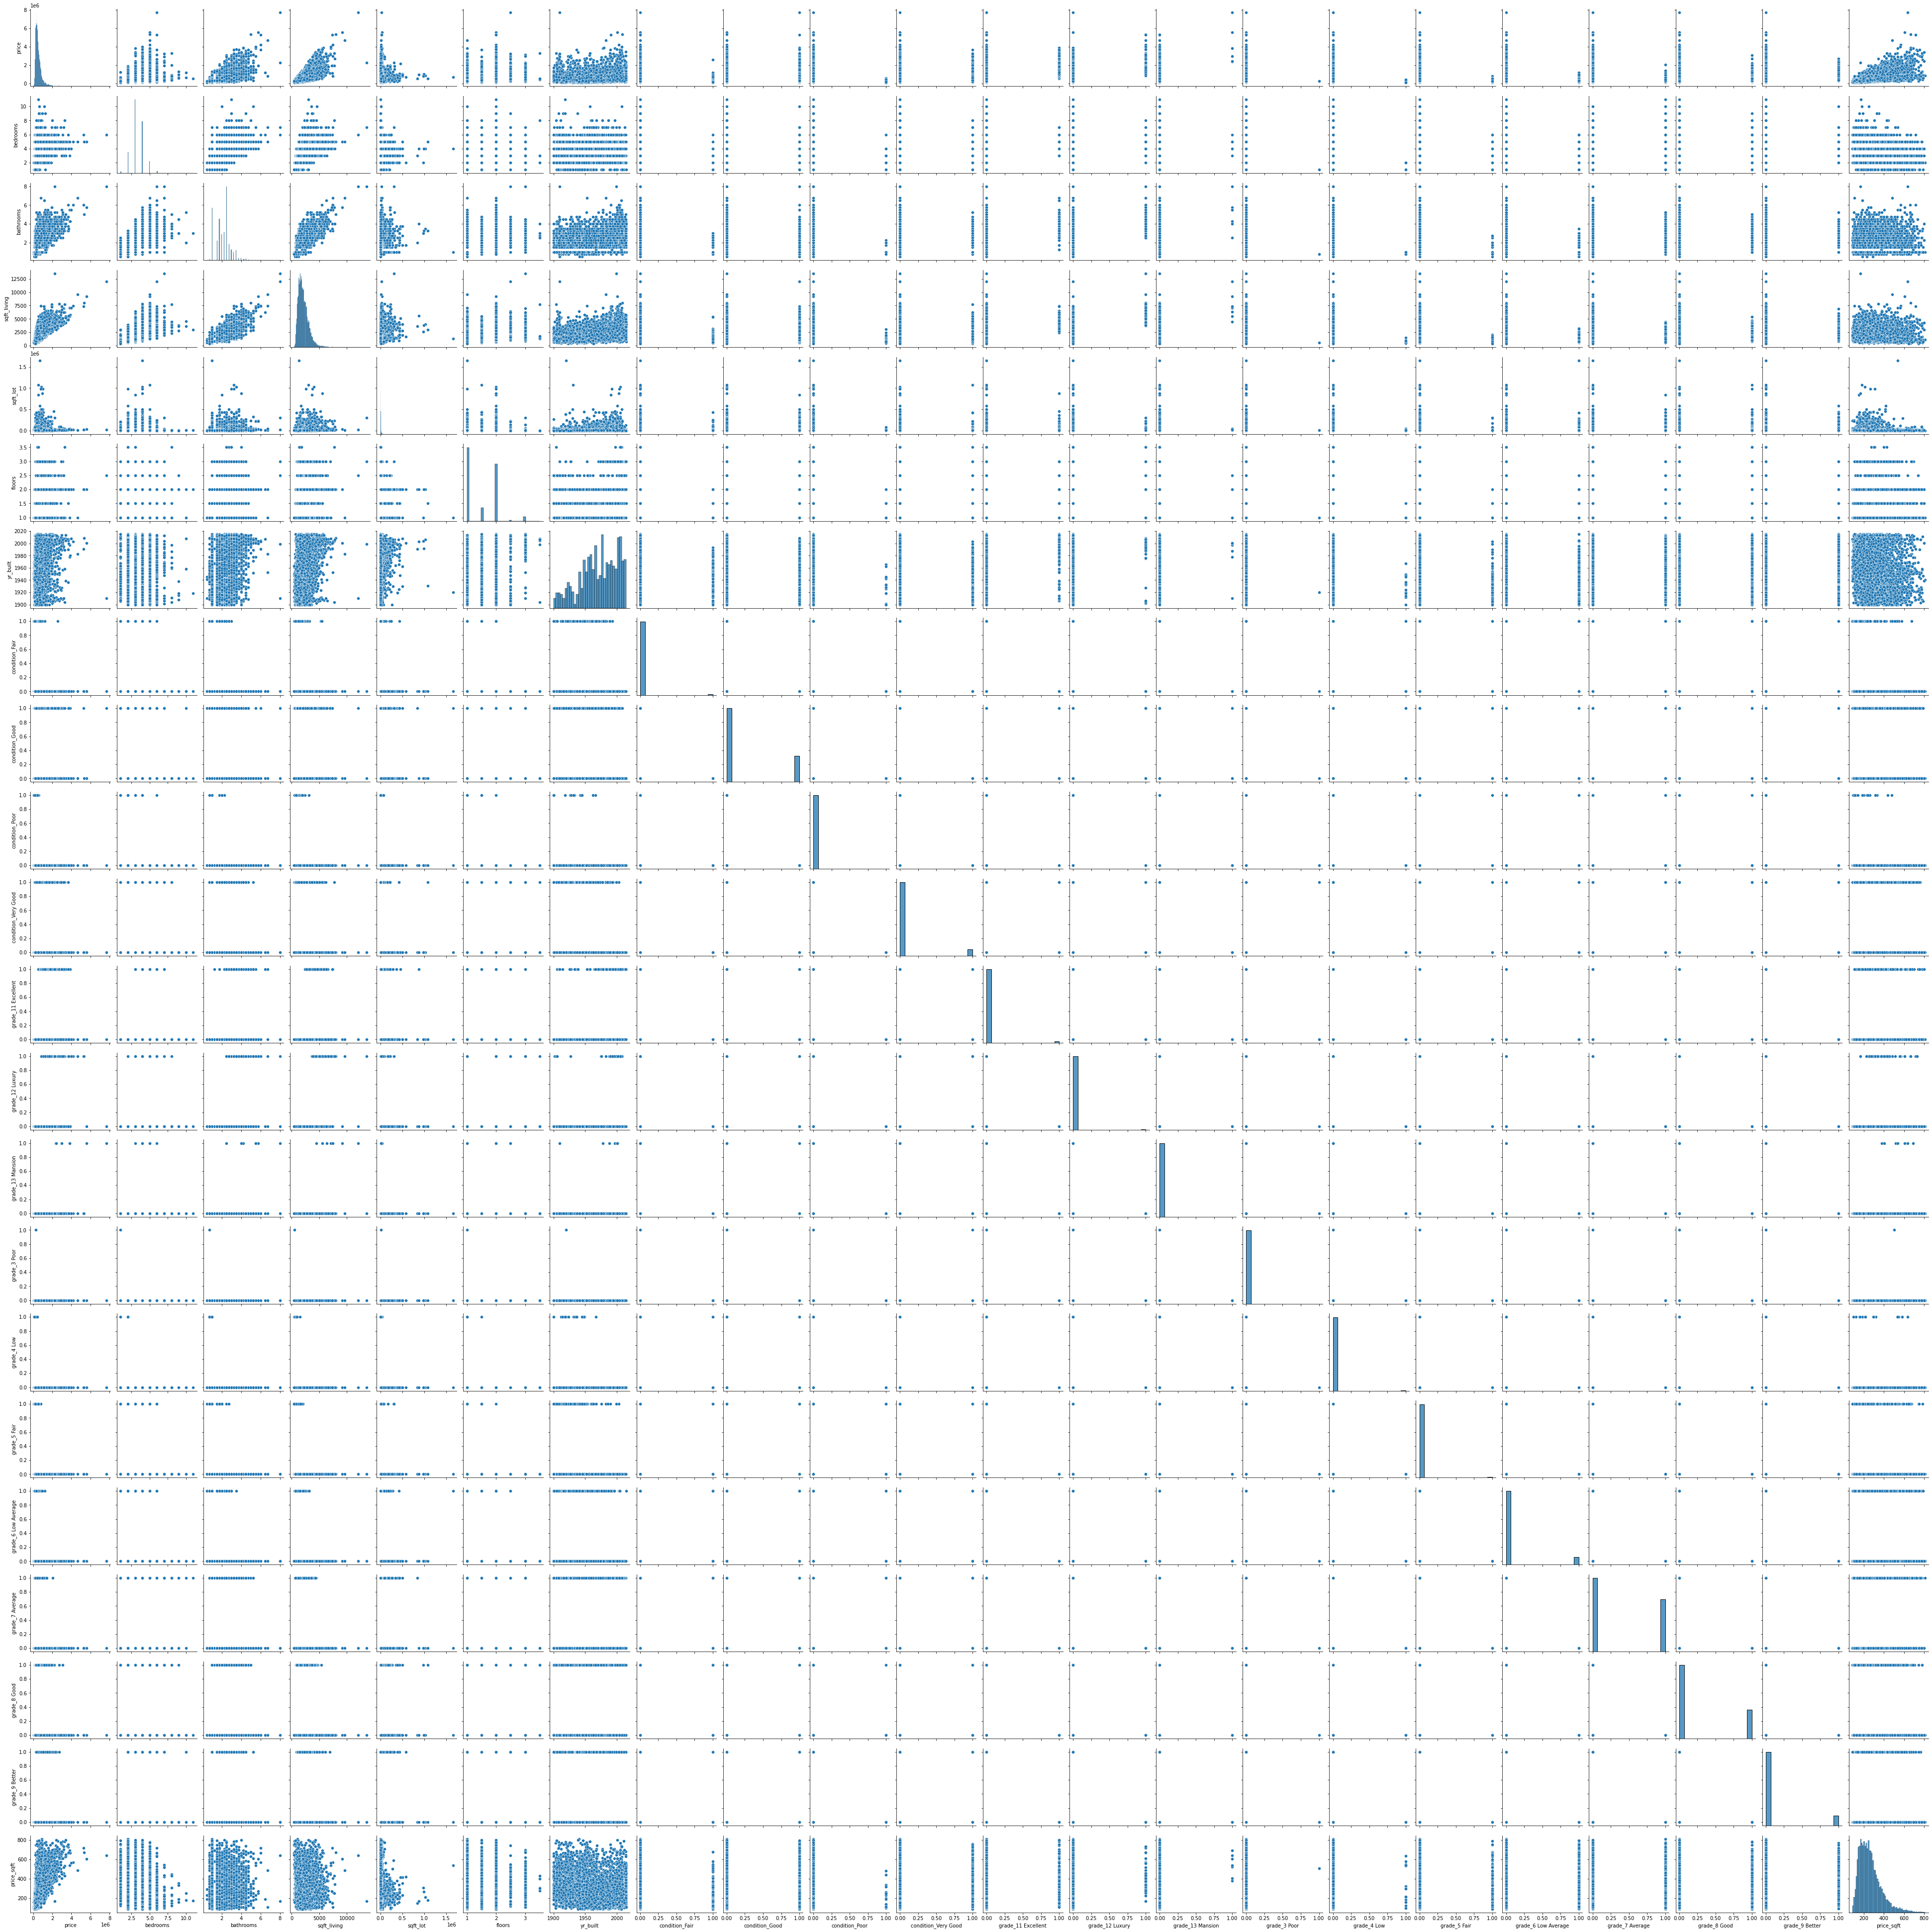

In [51]:
sns.pairplot(train_df)
plt.show()

In [20]:
# add constant term/y-intercept to train data
X_preds = sm.add_constant(X_train)

In [21]:
# First model
model = sm.OLS(endog=y_train, exog=X_preds).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_sqft   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     2704.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:39:48   Log-Likelihood:                -77073.
No. Observations:               14469   AIC:                         1.542e+05
Df Residuals:                   14447   BIC:                         1.544e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1353.5872     39.915     33.911      0.000    1275.348    1431.826
price                   0.0004   1.91e-06    185.532      0.000       0.000       0.000
bedrooms               -8.4041      0.605    -13.880      0.000      -9.591      -7.217
bathrooms              -2.7888      0.986     -2.828      0.005      -4.722      -0.856
sqft_living            -0.1081      0.001   -108.281      0.000      -0.110      -0.106
sqft_lot              7.12e-05   1.04e-05      6.858      0.000    5.09e-05    9.15e-05
floors                  9.2580      0.980      9.451      0.000       7.338      11.178
yr_built               -0.5145      0.020    -25.566      0.000      -0.554      -0.475
condition_Fair        -27.9253      4.672     -5.978      0.000     -37.082     -18.768
condition_Good         -4.2483      1.033     -4.113      0.000      -6.273      -2.224
condition_Poor        -34.7738     12.221     -2.846      0.004     -58.728     -10.820
condition_Very Good    -5.6136      1.658     -3.386      0.001      -8.863      -2.364
grade_11 Excellent    -15.9999      3.627     -4.411      0.000     -23.110      -8.890
grade_12 Luxury       -85.2115      6.926    -12.303      0.000     -98.787     -71.636
grade_13 Mansion     -400.3209     19.677    -20.345      0.000    -438.890    -361.752
grade_3 Poor          107.5580     49.955      2.153      0.031       9.640     205.476
grade_4 Low           -22.3454     12.861     -1.737      0.082     -47.555       2.864
grade_5 Fair          -41.2038      4.896     -8.417      0.000     -50.800     -31.608
grade_6 Low Average   -42.6546      3.123    -13.660      0.000     -48.775     -36.534
grade_7 Average       -28.7229      2.567    -11.190      0.000     -33.754     -23.692
grade_8 Good          -11.9872      2.320     -5.167      0.000     -16.534      -7.440
grade_9 Better          3.6717      2.253      1.629      0.103      -0.745       8.088
==============================================================================
Omnibus:                     4423.211   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           113190.371
Skew:                           0.900   Prob(JB):                         0.00
Kurtosis:                      16.583   Cond. No.                     7.92e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.92e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# Observations on 1st MultReg Model:
#     High pvalues:'grade_4 Low'
#     Solid R2 of 0.797
#     Coefficients hard to understand due to scaling.

In [52]:
train_df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,condition_Fair,condition_Good,condition_Poor,...,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,price_sqft
price,1.000000,0.321212,0.535071,0.701469,0.087953,0.256883,0.046539,-0.049659,-0.027707,-0.023275,...,0.295319,0.210446,-0.006291,-0.030759,-0.084815,-0.208612,-0.315544,-0.000313,0.233666,0.556867
bedrooms,0.321212,1.000000,0.530802,0.593719,0.039381,0.182357,0.155514,-0.045243,-0.013592,-0.029753,...,0.070403,0.028846,-0.021717,-0.064071,-0.115305,-0.243682,-0.108830,0.073662,0.162627,-0.211009
bathrooms,0.535071,0.530802,1.000000,0.760773,0.089418,0.503681,0.495821,-0.077658,-0.166993,-0.040012,...,0.163746,0.084226,-0.014774,-0.052383,-0.139461,-0.368742,-0.314323,0.189940,0.262195,-0.086735
sqft_living,0.701469,0.593719,0.760773,1.000000,0.183421,0.352124,0.313008,-0.061468,-0.081292,-0.027744,...,0.242360,0.127113,-0.014087,-0.050086,-0.128035,-0.313050,-0.356481,0.066627,0.318837,-0.091328
sqft_lot,0.087953,0.039381,0.089418,0.183421,1.000000,-0.004557,0.057133,0.024113,0.007653,0.001547,...,0.044795,0.007730,-0.000462,-0.003993,0.005050,-0.022032,-0.064988,-0.021722,0.045495,-0.040317
floors,0.256883,0.182357,0.503681,0.352124,-0.004557,1.000000,0.488199,-0.056208,-0.257455,-0.022145,...,0.060173,0.011787,-0.007630,-0.028611,-0.081460,-0.230047,-0.309989,0.203486,0.241953,0.004524
yr_built,0.046539,0.155514,0.495821,0.313008,0.057133,0.488199,1.000000,-0.069641,-0.257280,-0.048580,...,0.045906,0.008314,-0.014478,-0.042906,-0.131476,-0.312061,-0.207089,0.199046,0.219563,-0.296771
condition_Fair,-0.049659,-0.045243,-0.077658,-0.061468,0.024113,-0.056208,-0.069641,1.000000,-0.053875,-0.003110,...,-0.005949,-0.001995,-0.000754,0.066348,0.062390,0.078997,0.001640,-0.039923,-0.028618,-0.022040
condition_Good,-0.027707,-0.013592,-0.166993,-0.081292,0.007653,-0.257455,-0.257280,-0.053875,1.000000,-0.020377,...,-0.012471,0.001243,-0.004940,-0.000826,0.018755,0.055901,0.102882,-0.051237,-0.080653,0.038213
condition_Poor,-0.023275,-0.029753,-0.040012,-0.027744,0.001547,-0.022145,-0.048580,-0.003110,-0.020377,1.000000,...,-0.002250,-0.000755,-0.000285,-0.001141,0.128916,0.030525,-0.016592,-0.017074,-0.012618,-0.009636


In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# defining an empty dataframe to capture the VIF scores
vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

# label the scores with their related columns
vif["features"] = X_train.columns

vif

,VIF,features
0,7.842674,price
1,25.813833,bedrooms
2,26.407902,bathrooms
3,30.293117,sqft_living
4,1.205986,sqft_lot
5,13.743471,floors
6,80.147616,yr_built
7,1.034791,condition_Fair
8,1.563152,condition_Good
9,1.021288,condition_Poor


In [54]:
# Can't look at errors/residuals before modeling!
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [55]:
# Out of curiosity, check the score real fast
from sklearn.metrics import r2_score

print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
print(f"Test R2: {r2_score(y_test, test_preds):.4f}")

Train R2: 0.7972
Test R2: 0.7850


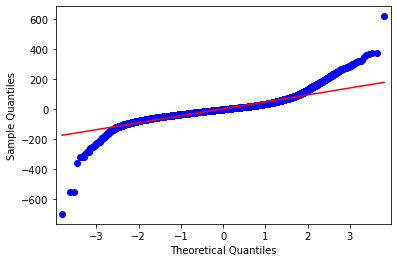

In [62]:
# Checking for normality

# Calculate our residuals
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds

# QQ Plot
sm.qqplot(train_residuals, line = 'r');

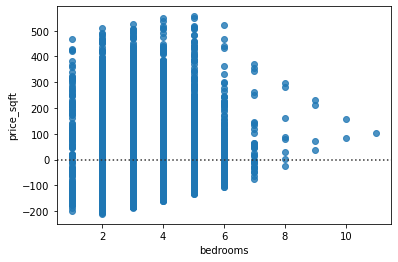

In [61]:
sns.residplot(x=X_train['bedrooms'], y=y_train)
plt.show()

## Trying out Standard Scaler

In [24]:
# Instantiate StandardScaler object
ss = StandardScaler()

In [46]:
#ss.fit(X_train)
X_train_scaled = ss.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [47]:
X_train_scaled

array([[ 2.26363853,  1.78193492,  2.11429391, ..., -0.84194402,
        -0.62838786,  2.71805557],
       [-0.5108184 , -0.41515211, -0.15565065, ...,  1.18772742,
        -0.62838786, -0.36791006],
       [ 0.38608491,  0.6833914 , -1.45276183, ..., -0.84194402,
        -0.62838786, -0.36791006],
       ...,
       [-0.65453905,  0.6833914 , -0.80420624, ..., -0.84194402,
        -0.62838786, -0.36791006],
       [-0.80258213, -2.61223914, -1.77703962, ..., -0.84194402,
        -0.62838786, -0.36791006],
       [ 0.00787267,  0.6833914 ,  0.49290494, ..., -0.84194402,
         1.59137384, -0.36791006]])

In [48]:
X_train_scaled_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,condition_Fair,condition_Good,condition_Poor,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
19709,2.263639,1.781935,2.114294,1.342271,-0.248753,0.932178,1.464378,-0.090678,-0.594139,-0.034297,...,-0.137896,-0.065601,-0.022001,-0.008314,-0.033272,-0.107731,-0.321442,-0.841944,-0.628388,2.718056
4800,-0.510818,-0.415152,-0.155651,-0.443020,-0.034101,-0.917731,0.782293,-0.090678,-0.594139,-0.034297,...,-0.137896,-0.065601,-0.022001,-0.008314,-0.033272,-0.107731,-0.321442,1.187727,-0.628388,-0.367910
13225,0.386085,0.683391,-1.452762,-0.581348,-0.000589,0.007224,-1.400379,-0.090678,-0.594139,-0.034297,...,-0.137896,-0.065601,-0.022001,-0.008314,-0.033272,-0.107731,3.110985,-0.841944,-0.628388,-0.367910
16111,0.696759,-0.415152,0.492905,0.726281,-0.140965,-0.917731,-0.513669,-0.090678,-0.594139,-0.034297,...,-0.137896,-0.065601,-0.022001,-0.008314,-0.033272,-0.107731,-0.321442,-0.841944,1.591374,-0.367910
17711,0.088918,-1.513696,-0.804206,-0.743451,-0.230062,0.932178,-1.059337,-0.090678,-0.594139,-0.034297,...,-0.137896,-0.065601,-0.022001,-0.008314,-0.033272,-0.107731,-0.321442,1.187727,-0.628388,-0.367910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,-0.275787,-0.415152,0.492905,0.153518,-0.230306,0.932178,1.123336,-0.090678,-0.594139,-0.034297,...,-0.137896,-0.065601,-0.022001,-0.008314,-0.033272,-0.107731,-0.321442,1.187727,-0.628388,-0.367910
21575,0.080814,0.683391,0.817183,0.737088,-0.277714,0.932178,1.464378,-0.090678,-0.594139,-0.034297,...,-0.137896,-0.065601,-0.022001,-0.008314,-0.033272,-0.107731,-0.321442,-0.841944,1.591374,-0.367910
5390,-0.654539,0.683391,-0.804206,-0.602962,-0.152427,-0.917731,0.168416,-0.090678,1.683107,-0.034297,...,-0.137896,-0.065601,-0.022001,-0.008314,-0.033272,-0.107731,3.110985,-0.841944,-0.628388,-0.367910
860,-0.802582,-2.612239,-1.777040,-1.845750,-0.006405,-0.917731,-0.274939,-0.090678,-0.594139,-0.034297,...,-0.137896,-0.065601,-0.022001,-0.008314,-0.033272,9.282384,-0.321442,-0.841944,-0.628388,-0.367910


In [49]:
model = sm.OLS(endog=y_train , exog=X_train_scaled ).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             price_sqft   R-squared (uncentered):                   0.119
Model:                            OLS   Adj. R-squared (uncentered):              0.118
Method:                 Least Squares   F-statistic:                              92.82
Date:                Tue, 21 Jun 2022   Prob (F-statistic):                        0.00
Time:                        15:51:49   Log-Likelihood:                     -1.0147e+05
No. Observations:               14469   AIC:                                  2.030e+05
Df Residuals:                   14448   BIC:                                  2.031e+05
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           130.9723      3.810     34.373      0.000     123.504     138.441
x2            -7.6502      2.975     -2.572      0.010     -13.481      -1.819
x3            -2.1500      4.104     -0.524      0.600     -10.194       5.894
x4          -100.0581      4.988    -20.061      0.000    -109.834     -90.282
x5             2.9256      2.302      1.271      0.204      -1.587       7.439
x6             5.0046      2.858      1.751      0.080      -0.598      10.607
x7           -15.0862      3.185     -4.737      0.000     -21.329      -8.843
x8            -2.5115      2.268     -1.107      0.268      -6.957       1.934
x9            -1.8655      2.448     -0.762      0.446      -6.664       2.933
x10           -1.1912      2.260     -0.527      0.598      -5.620       3.238
x11           -1.5202      2.423     -0.627      0.530      -6.270       3.230
x12           -2.1652      2.649     -0.817      0.414      -7.358       3.028
x13           -5.5660      2.442     -2.279      0.023     -10.352      -0.780
x14           -8.8030      2.335     -3.769      0.000     -13.381      -4.225
x15            0.8941      2.242      0.399      0.690      -3.499       5.288
x16           -0.7427      2.307     -0.322      0.748      -5.265       3.780
x17           -4.3880      2.814     -1.559      0.119      -9.904       1.128
x18          -12.4270      4.910     -2.531      0.011     -22.052      -2.802
x19          -14.1515      6.826     -2.073      0.038     -27.531      -0.772
x20           -5.4002      5.641     -0.957      0.338     -16.457       5.656
x21            1.1898      3.941      0.302      0.763      -6.535       8.915
==============================================================================
Omnibus:                     4423.211   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           113190.371
Skew:                           0.900   Prob(JB):                         0.00
Kurtosis:                      16.583   Cond. No.                         9.41
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
## Observations:
#     this is laughably worse on R2 - 0.119
#     LOTS of high pvalues.

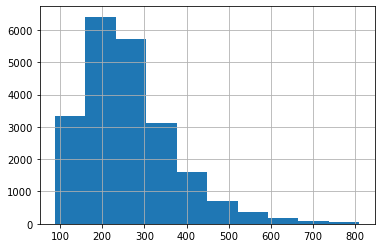

In [39]:
y.hist();

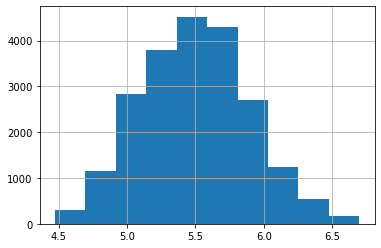

In [40]:
y_scld=np.log(y)
y_scld.hist();

In [63]:
# Model with log-scaled y. R-squared degraded~3 points

X = X_preds
y = np.log(y_train)
model2 = sm.OLS(endog=y, exog=X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_sqft   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     2206.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:04:41   Log-Likelihood:                 3294.3
No. Observations:               14469   AIC:                            -6545.
Df Residuals:                   14447   BIC:                            -6378.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   9.5802      0.154     62.015      0.000       9.277       9.883
price                1.206e-06   7.38e-09    163.354      0.000    1.19e-06    1.22e-06
bedrooms               -0.0321      0.002    -13.709      0.000      -0.037      -0.028
bathrooms              -0.0023      0.004     -0.592      0.554      -0.010       0.005
sqft_living            -0.0004   3.86e-06   -103.095      0.000      -0.000      -0.000
sqft_lot              3.42e-07   4.02e-08      8.511      0.000    2.63e-07    4.21e-07
floors                  0.0379      0.004      9.997      0.000       0.030       0.045
yr_built               -0.0019   7.79e-05    -24.288      0.000      -0.002      -0.002
condition_Fair         -0.1326      0.018     -7.336      0.000      -0.168      -0.097
condition_Good         -0.0148      0.004     -3.700      0.000      -0.023      -0.007
condition_Poor         -0.1551      0.047     -3.280      0.001      -0.248      -0.062
condition_Very Good     0.0003      0.006      0.053      0.958      -0.012       0.013
grade_11 Excellent     -0.0480      0.014     -3.421      0.001      -0.076      -0.021
grade_12 Luxury        -0.2806      0.027    -10.469      0.000      -0.333      -0.228
grade_13 Mansion       -1.4382      0.076    -18.885      0.000      -1.587      -1.289
grade_3 Poor            0.1566      0.193      0.810      0.418      -0.222       0.536
grade_4 Low            -0.2395      0.050     -4.812      0.000      -0.337      -0.142
grade_5 Fair           -0.2684      0.019    -14.166      0.000      -0.306      -0.231
grade_6 Low Average    -0.2313      0.012    -19.139      0.000      -0.255      -0.208
grade_7 Average        -0.1664      0.010    -16.747      0.000      -0.186      -0.147
grade_8 Good           -0.0818      0.009     -9.113      0.000      -0.099      -0.064
grade_9 Better          0.0011      0.009      0.123      0.902      -0.016       0.018
==============================================================================
Omnibus:                     4528.188   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61907.239
Skew:                          -1.119   Prob(JB):                         0.00
Kurtosis:                      12.883   Cond. No.                     7.92e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.92e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
kc_encoded['grade_5 Fair'].sum()

In [ ]:
kc_encoded['grade_4 Low'].sum()

# Maybe drop since pvalues are 

In [ ]:
kc_encoded['condition_Poor'].sum()

# Maybe drop since pvalues are very high and minimal number of properties.

In [ ]:
kc_encoded['grade_8 Good'].sum()

# Too big a population to drop.

In [ ]:
# Model with log-scaled y, and dropped high pvalue columns

X = train_df.drop(columns=['price_sqft', 'floors', 'condition_Poor', 'grade_13 Mansion', 'grade_8 Good', 'grade_4 Low', 'grade_3 Poor'])
y = np.log(train_df['price_sqft'])
model3 = sm.OLS(endog=y, exog=X).fit()
model3.summary()

## Visualizing

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(16,20))


for xcol, ax in zip(kc_encoded.columns[:], [x for v in axes for x in v]):
    kc_encoded.plot.scatter(x=xcol, y='price_sqft', ax=ax, alpha=0.5, color='b')


In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
kc_encoded.hist(ax = ax);

# Full EDA

In [ ]:
kc_housing = pd.read_csv('../data/kc_house_data.csv')


In [ ]:
kc_housing.shape

In [ ]:
kc_housing.describe()

In [ ]:
columns_of_note = list(kc_housing.columns)[3:8]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,16))


for xcol, ax in zip(kc_housing.columns[3:8], [x for v in axes for x in v]):
    kc_housing.plot.scatter(x=xcol, y='price', ax=ax, alpha=0.5, color='b')


In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
kc_housing.hist(ax = ax);

In [ ]:
kc_housing.info()

In [ ]:
# Looking for NANs
kc_housing.isna().sum()

#### Added price/sqft feature

In [ ]:
kc_housing['price_sqft'] = kc_housing['price']/kc_housing['sqft_living']

In [ ]:
kc_housing.head()

#### Addressing Waterfront

There are ~2400 NA cells, no easy way to determine if waterfront or not. Recommend we drop this whole column--even if all of the NA cells should be YES for waterfront, that's less than 10% of our dataset, likely not meaningful to our analysis.

Drop Waterfront.

In [ ]:
kc_housing['waterfront'].value_counts()

In [ ]:
sum(kc_housing['waterfront'].isna())

In [ ]:
kc_housing['waterfront'] = kc_housing['waterfront'].fillna('N/A')

In [ ]:
kc_housing.sort_values(by='waterfront', ascending=False)

#### Addressing View

Doesn't seem to be many rows with na. Maybe encode as NA or preferably drop?+

Drop rows with N/A

In [ ]:
sum(kc_housing['view'].isna())

In [ ]:
kc_housing['view'].value_counts()

In [ ]:
# code to replace empty with N/A - add inplace if we decide to take this approach.
kc_housing['view'] = kc_housing['view'].fillna('N/A')

#### Addressing yr_renovated

Absent from simple data, maybe we add on later

~ 78% have 0 values, so assume they were not rennovated. I think rennovations are a meaningful datapoint, so we should encode this somehow. We could think about how recent the rennovation was to see if there is a meaningful relationship--for example, a home rennovated in 2020 is likely to sell better than a home rennovated only in 1980. Maybe we do some research on this and decide on a breakpoint for rennovated before/after? We could do a simple linear regression between yr renovated and price...

In [ ]:
sum(kc_housing['yr_renovated'].isna())

In [ ]:
kc_housing['yr_renovated'].value_counts(sort=False).head(75)

In [ ]:
kc_housing['yr_renovated'] = kc_housing['yr_renovated'].fillna('N/A')

In [ ]:
#dropping N/A for now to make model function.
kc_housing = kc_housing[(kc_housing.yr_renovated != 'N/A')]

#### Duplicate Properties

In [ ]:
# Looking for duplicate properties

kc_housing['id'].duplicated().sum()

In [ ]:
# Identify instances of the same property appearing more than once in the data set based on lattitude, longitude
# How do we treat this? Might not matter since there is only ~4-5 months of data here. as long as listing date 
# is different, probably OK to treat these as unique listings.


kc_housing[kc_housing.duplicated(subset=['id'], keep=False)].sort_values('id')

#### Addressing grade

This we need to encode as an ordinal.

In [ ]:
kc_housing['grade'].value_counts()

In [ ]:
# Create new column for numerical grade. 
# Should either drop df['grade'] or omit it from clean df.
kc_housing['grade_num']= kc_housing['grade'].apply(lambda x: x[:1]).astype(int)

In [ ]:
kc_housing['grade_num']

In [ ]:
kc_housing.info()

#### Addressing sqft_basement

Recommend we drop rows with N/A since we don't have an easy way to encode.
We have 454 unknown values here. need to drop or encode somehow. Maybe has basement or no basement?


In [ ]:
kc_housing['sqft_basement'].value_counts()

In [ ]:
kc_housing = kc_housing[(kc_housing.sqft_basement != '?')]

In [ ]:
kc_housing['sqft_basement'].value_counts()

# Encoding Categoricals

In [ ]:
# Identify catgeorical values & create new df with only the categorical columns.
categoricals = ['bedrooms', 'floors', 'condition', 'grade', 'view','waterfront']
cat_df = kc_housing[categoricals]
cat_df.head()

In [ ]:
# OneHot encoding for categorical variables. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
categorical_cats = ohe.fit_transform(cat_df)
categorical_cats.todense()
categorical_df = pd.DataFrame(categorical_cats.todense(), columns=ohe.get_feature_names(categoricals))
categorical_df.head()

In [ ]:
categorical_df.shape

In [ ]:
kc_housing.shape

In [ ]:
# Append categorical dummies to original dataframe, and drop origical categorical columns.
data = kc_housing.drop(columns=categoricals)
kc_encoded = pd.concat([data.reset_index(drop=True), categorical_df.reset_index(drop=True)], axis=1)

In [ ]:
kc_encoded.shape

In [ ]:
kc_encoded.info()

# Nonsense Model with all columns

In [ ]:
X = kc_encoded.drop(columns=['date', 'lat', 'long', 'id','price_sqft','yr_renovated','sqft_basement'])
y = kc_encoded['price_sqft']

In [ ]:
X.isna().sum()

In [ ]:

model = sm.OLS(endog=y, exog=X).fit()
model.summary()